In [ ]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 97.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="lqiMHBOSIqLGCKvZgB67")
project = rf.workspace("pavan-g-hzipt").project("animal2-ps24m")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
import os

def show_structure_limited(root_dir, indent="", max_files=2):
    try:
        items = sorted(os.listdir(root_dir))
    except PermissionError:
        return

    files_shown = 0

    for item in items:
        path = os.path.join(root_dir, item)

        if os.path.isdir(path):
            print(f"{indent}📁 {item}/")
            show_structure_limited(path, indent + "   ", max_files)

        else:
            if files_shown < max_files:
                print(f"{indent}📄 {item}")
                files_shown += 1

# Display dataset structure (only 2 files per folder)
show_structure_limited("/content/animal2-3")


📄 README.dataset.txt
📄 README.roboflow.txt
📁 test/
   📁 images/
      📄 01_mp4-0004_jpg.rf.04e260ea5a233e5870a9e4875fdad0da.jpg
      📄 01_mp4-0009_jpg.rf.bd5075eee28621c3186a13dc6a5d9eeb.jpg
   📁 labels/
      📄 01_mp4-0004_jpg.rf.04e260ea5a233e5870a9e4875fdad0da.txt
      📄 01_mp4-0009_jpg.rf.bd5075eee28621c3186a13dc6a5d9eeb.txt
📁 train/
   📁 images/
      📄 01_mp4-0001_jpg.rf.3d5bbd5c412af7bba124c9a06e47032d.jpg
      📄 01_mp4-0002_jpg.rf.7083904e024a37d618efbd90db1b8a79.jpg
   📁 labels/
      📄 01_mp4-0001_jpg.rf.3d5bbd5c412af7bba124c9a06e47032d.txt
      📄 01_mp4-0002_jpg.rf.7083904e024a37d618efbd90db1b8a79.txt
📁 valid/
   📁 images/
      📄 01_mp4-0005_jpg.rf.605a1c4a2a73cb02f8275ff4fb1031a8.jpg
      📄 01_mp4-0022_jpg.rf.69a8e66778f2b04ef56ead6db19642d4.jpg
   📁 labels/
      📄 01_mp4-0005_jpg.rf.605a1c4a2a73cb02f8275ff4fb1031a8.txt
      📄 01_mp4-0022_jpg.rf.69a8e66778f2b04ef56ead6db19642d4.txt


In [ ]:
classes = [
    "cheetah", "bison", "bear", "camel", "deer", "elephant",
    "giraffe", "kangaroo", "lion", "tiger", "wolf", "zebra"
]


In [ ]:
import os, json, cv2

def yolo_to_coco(images_dir, labels_dir, classes, output_json):
    coco = {"images": [], "annotations": [], "categories": []}

    for i, name in enumerate(classes):
        coco["categories"].append({"id": i+1, "name": name})

    ann_id, img_id = 1, 1

    for img_name in sorted(os.listdir(images_dir)):
        if not img_name.lower().endswith((".jpg",".png",".jpeg")):
            continue

        img_path = os.path.join(images_dir, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        h, w, _ = img.shape
        label_path = os.path.join(labels_dir, img_name.rsplit(".",1)[0] + ".txt")

        if not os.path.exists(label_path):
            continue

        coco["images"].append({
            "id": img_id,
            "file_name": img_name,
            "width": w,
            "height": h
        })

        with open(label_path) as f:
            for line in f:
                values = list(map(float, line.split()))

                if len(values) < 5:
                    continue   # skip invalid rows

                cls = int(values[0])
                x, y, bw, bh = values[1:5]   # ✅ TAKE ONLY BBOX

                x_min = (x - bw/2) * w
                y_min = (y - bh/2) * h

                coco["annotations"].append({
                    "id": ann_id,
                    "image_id": img_id,
                    "category_id": cls + 1,
                    "bbox": [x_min, y_min, bw*w, bh*h],
                    "area": bw*w*bh*h,
                    "iscrowd": 0
                })

                ann_id += 1

        img_id += 1

    with open(output_json, "w") as f:
        json.dump(coco, f, indent=4)

    print(f"✅ COCO annotations saved to {output_json}")


In [ ]:
yolo_to_coco(
    "animal2-3/train/images",
    "animal2-3/train/labels",
    classes,
    "train.json"
)

yolo_to_coco(
    "animal2-3/valid/images",
    "animal2-3/valid/labels",
    classes,
    "val.json"
)

✅ COCO annotations saved to train.json
✅ COCO annotations saved to val.json


In [ ]:
import json
with open("train.json") as f:
    coco = json.load(f)

print("Images:", len(coco["images"]))
print("Annotations:", len(coco["annotations"]))
print("Classes:", len(coco["categories"]))


Images: 8371
Annotations: 35556
Classes: 12


In [ ]:
import torch
from torchvision.datasets import CocoDetection
from torchvision import transforms

class CocoDataset(CocoDetection):
    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)

        boxes, labels = [], []
        for obj in target:
            x, y, w, h = obj["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(obj["category_id"])

        # skip images without annotations
        if len(boxes) == 0:
            return None

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        return transforms.ToTensor()(img), target

In [ ]:
def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    return tuple(zip(*batch))


In [ ]:
from torch.utils.data import DataLoader, Subset
import random

full_train_ds = CocoDataset(
    "animal2-3/train/images",
    "train.json"
)

MAX_IMAGES = 1200
indices = list(range(len(full_train_ds)))
random.shuffle(indices)
indices = indices[:MAX_IMAGES]

train_ds = Subset(full_train_ds, indices)

train_loader = DataLoader(
    train_ds,
    batch_size=2,          # 1200 images → 600 batches
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)


loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


In [ ]:
print("Total images in full dataset:", len(full_train_ds))
print("Images used per epoch:", len(train_ds))


Total images in full dataset: 8371
Images used per epoch: 1200


Input Image
   ↓
ResNet-101 (Backbone)
   ↓
Feature Pyramid Network (FPN)
   ↓
Region Proposal Network (RPN)
   ↓
RoI Pooling
   ↓
Detection Head
   ↓
# Bounding Boxes + **Classes** **bold text**

In [ ]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

backbone = resnet_fpn_backbone("resnet101", weights="DEFAULT")

model = FasterRCNN(
    backbone=backbone,
    num_classes=13   # 12 animals + background
)


Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.


Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


100%|██████████| 171M/171M [00:00<00:00, 192MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)


In [ ]:
from tqdm import tqdm

EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, targets in tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{EPOCHS} (max 1200 images)"
    ):
        images = [img.to(device) for img in images]
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"✅ Epoch {epoch+1} Loss: {total_loss:.4f}")

Epoch 1/20 (max 1200 images): 100%|██████████| 600/600 [05:33<00:00,  1.80it/s]


✅ Epoch 1 Loss: 486.2891


Epoch 2/20 (max 1200 images): 100%|██████████| 600/600 [05:32<00:00,  1.80it/s]


✅ Epoch 2 Loss: 460.4175


Epoch 3/20 (max 1200 images): 100%|██████████| 600/600 [05:34<00:00,  1.80it/s]


✅ Epoch 3 Loss: 419.5115


Epoch 4/20 (max 1200 images): 100%|██████████| 600/600 [05:33<00:00,  1.80it/s]


✅ Epoch 4 Loss: 401.0735


Epoch 5/20 (max 1200 images): 100%|██████████| 600/600 [05:33<00:00,  1.80it/s]


✅ Epoch 5 Loss: 347.5640


Epoch 6/20 (max 1200 images): 100%|██████████| 600/600 [05:33<00:00,  1.80it/s]


✅ Epoch 6 Loss: 323.4441


Epoch 7/20 (max 1200 images): 100%|██████████| 600/600 [05:34<00:00,  1.79it/s]


✅ Epoch 7 Loss: 282.7081


Epoch 8/20 (max 1200 images): 100%|██████████| 600/600 [05:34<00:00,  1.79it/s]


✅ Epoch 8 Loss: 257.2411


Epoch 9/20 (max 1200 images): 100%|██████████| 600/600 [05:34<00:00,  1.79it/s]


✅ Epoch 9 Loss: 244.7095


Epoch 10/20 (max 1200 images): 100%|██████████| 600/600 [05:35<00:00,  1.79it/s]


✅ Epoch 10 Loss: 234.8831


Epoch 11/20 (max 1200 images): 100%|██████████| 600/600 [05:35<00:00,  1.79it/s]


✅ Epoch 11 Loss: 221.0497


Epoch 12/20 (max 1200 images): 100%|██████████| 600/600 [05:35<00:00,  1.79it/s]


✅ Epoch 12 Loss: 214.8626


Epoch 13/20 (max 1200 images): 100%|██████████| 600/600 [05:35<00:00,  1.79it/s]


✅ Epoch 13 Loss: 214.1932


Epoch 14/20 (max 1200 images): 100%|██████████| 600/600 [05:35<00:00,  1.79it/s]


✅ Epoch 14 Loss: 202.0403


Epoch 15/20 (max 1200 images): 100%|██████████| 600/600 [05:35<00:00,  1.79it/s]


✅ Epoch 15 Loss: 196.5086


Epoch 16/20 (max 1200 images): 100%|██████████| 600/600 [05:35<00:00,  1.79it/s]


✅ Epoch 16 Loss: 188.2178


Epoch 17/20 (max 1200 images): 100%|██████████| 600/600 [05:36<00:00,  1.79it/s]


✅ Epoch 17 Loss: 183.4347


Epoch 18/20 (max 1200 images): 100%|██████████| 600/600 [05:35<00:00,  1.79it/s]


✅ Epoch 18 Loss: 185.0379


Epoch 19/20 (max 1200 images): 100%|██████████| 600/600 [05:35<00:00,  1.79it/s]


✅ Epoch 19 Loss: 232.1510


Epoch 20/20 (max 1200 images): 100%|██████████| 600/600 [05:35<00:00,  1.79it/s]

✅ Epoch 20 Loss: 183.3688


In [ ]:
import torch

MODEL_PATH = "fasterrcnn_resnet101_animals.pth"
torch.save(model.state_dict(), MODEL_PATH)

print(f"✅ Model saved at {MODEL_PATH}")

✅ Model saved at fasterrcnn_resnet101_animals.pth


In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "epochs": EPOCHS
}, "fasterrcnn_resnet101_checkpoint.pth")


In [ ]:
val_ds = CocoDataset("animal2-3/valid/images", "val.json")

val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)


loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


In [ ]:
val_ds = CocoDataset(
    "animal2-3/valid/images",
    "val.json"
)

val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]

        outputs = model(images)

        for gt, out in zip(targets, outputs):
            gt_labels = gt["labels"].cpu().numpy()

            if len(out["labels"]) == 0:
                continue

            pred_labels = out["labels"].cpu().numpy()

            min_len = min(len(gt_labels), len(pred_labels))
            y_true.extend(gt_labels[:min_len])
            y_pred.extend(pred_labels[:min_len])

In [ ]:
accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\n✅ Training Accuracy (object-level): {accuracy*100:.2f}%\n")



✅ Training Accuracy (object-level): 98.95%



In [ ]:
print("📄 Training Classification Report:\n")

print(classification_report(
    y_true,
    y_pred,
    target_names=classes,
    digits=4
))

📄 Training Classification Report:

              precision    recall  f1-score   support

     cheetah     0.9966    1.0000    0.9983       291
       bison     0.9952    0.9181    0.9551       452
        bear     0.9248    1.0000    0.9609       123
       camel     0.9952    0.9968    0.9960      1254
        deer     0.9597    1.0000    0.9795       286
    elephant     0.9931    0.9863    0.9897       583
     giraffe     1.0000    0.9917    0.9958       360
    kangaroo     0.9830    1.0000    0.9914       462
        lion     0.9722    1.0000    0.9859       315
       tiger     1.0000    1.0000    1.0000       130
        wolf     1.0000    0.9964    0.9982       276
       zebra     0.9981    1.0000    0.9991       532

    accuracy                         0.9895      5064
   macro avg     0.9848    0.9908    0.9875      5064
weighted avg     0.9898    0.9895    0.9895      5064



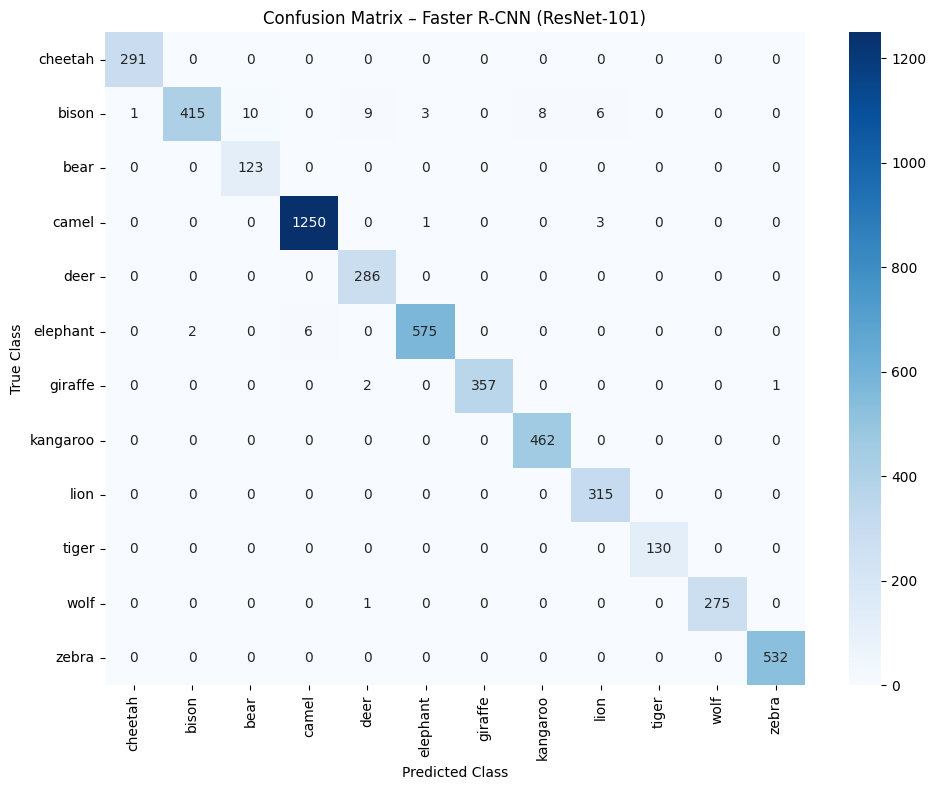

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix – Faster R-CNN (ResNet-101)")
plt.tight_layout()
plt.show()

In [ ]:
train_loss_history = []


In [ ]:
train_loss_history.append(total_loss)


In [ ]:
print(f"✅ Epoch {epoch+1} Loss: {total_loss:.4f}")
train_loss_history.append(total_loss)


✅ Epoch 20 Loss: 183.3688


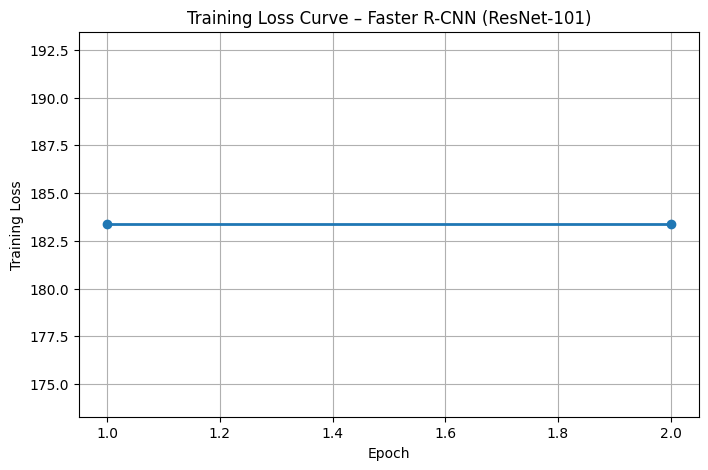

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(
    range(1, len(train_loss_history) + 1),
    train_loss_history,
    marker='o',
    linewidth=2
)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve – Faster R-CNN (ResNet-101)")
plt.grid(True)
plt.show()

In [ ]:
import torch
import cv2
import numpy as np
import os
from tqdm import tqdm
from google.colab import files
import matplotlib.pyplot as plt


In [ ]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# rebuild model architecture
backbone = resnet_fpn_backbone("resnet101", weights=None)
model = FasterRCNN(backbone, num_classes=13)

# load trained weights
model.load_state_dict(torch.load("fasterrcnn_resnet101_animals.pth", map_location="cpu"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print("✅ Faster R-CNN model loaded successfully")


Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.


✅ Faster R-CNN model loaded successfully


In [ ]:
uploaded = files.upload()
video_path = list(uploaded.keys())[0]

Saving lionn7.mp4 to lionn7.mp4


In [ ]:
cap = cv2.VideoCapture(video_path)

fps = int(cap.get(cv2.CAP_PROP_FPS))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

out_path = "fasterrcnn_output_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

print(f"Frames: {total_frames}, Resolution: {width}x{height}, FPS: {fps}")

Frames: 333, Resolution: 1918x818, FPS: 30


In [ ]:
classes = [
    "cheetah","bison","bear","camel","deer","elephant",
    "giraffe","kangaroo","lion","tiger","wolf","zebra"
]

  0%|          | 0/333 [00:00<?, ?it/s]

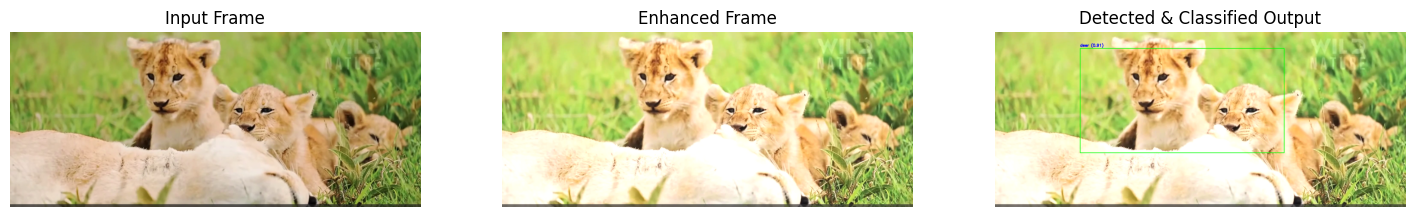

  9%|▉         | 30/333 [00:07<00:49,  6.08it/s]

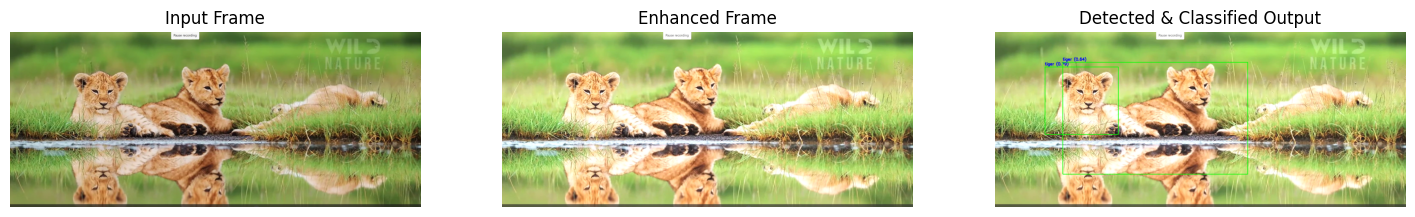

 18%|█▊        | 60/333 [00:12<00:43,  6.33it/s]

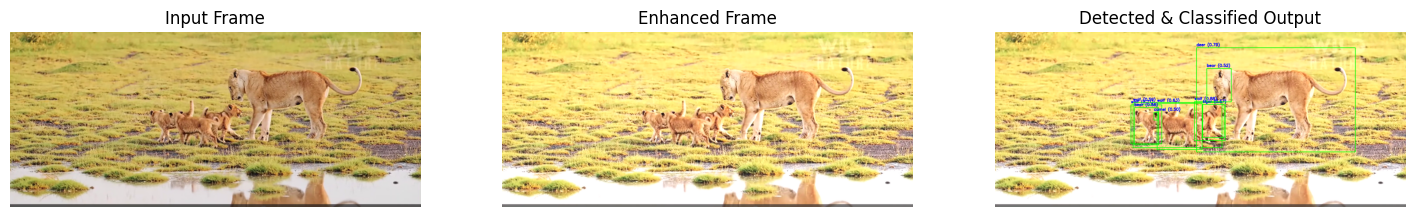

 27%|██▋       | 90/333 [00:17<00:41,  5.84it/s]

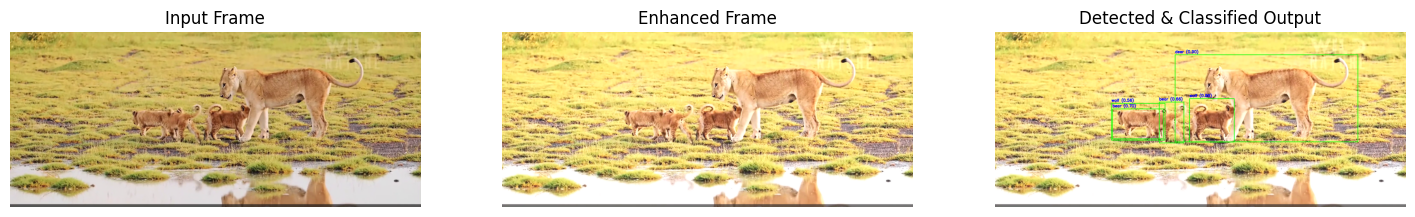

 36%|███▌      | 120/333 [00:23<00:35,  6.00it/s]

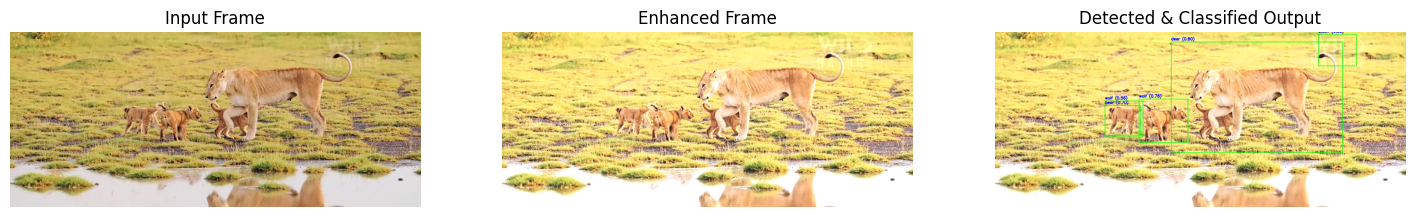

 45%|████▌     | 150/333 [00:28<00:29,  6.22it/s]

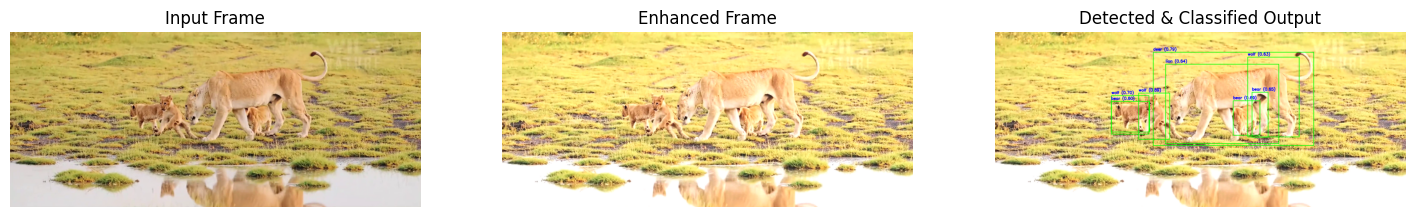

 54%|█████▍    | 180/333 [00:34<00:31,  4.82it/s]

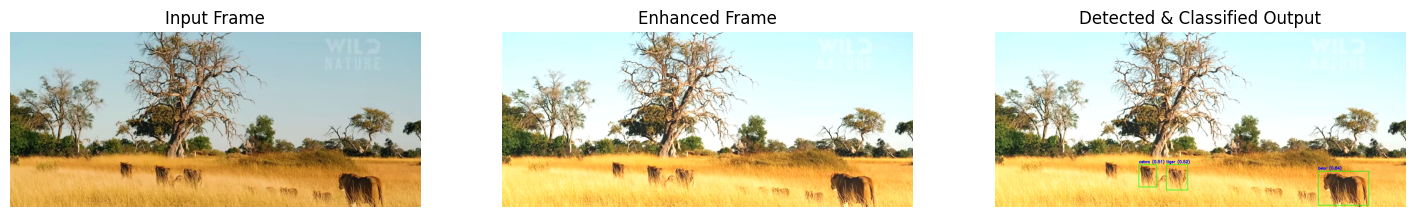

 63%|██████▎   | 210/333 [00:41<00:20,  6.11it/s]

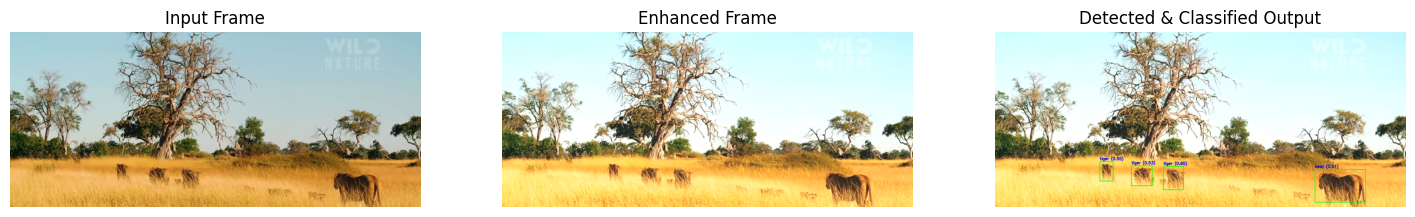

 72%|███████▏  | 240/333 [00:46<00:15,  5.94it/s]

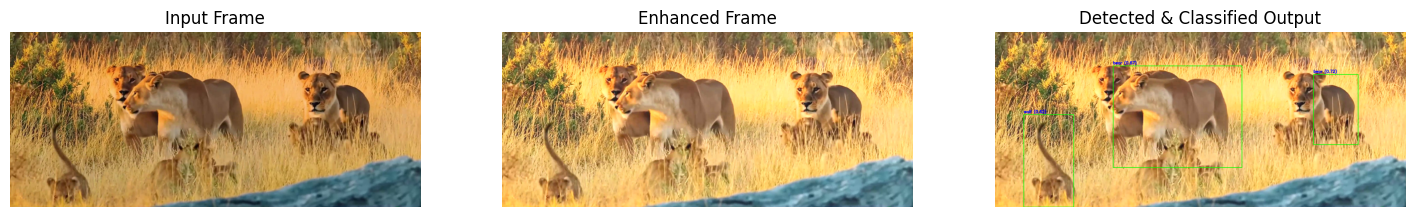

 81%|████████  | 270/333 [00:52<00:10,  6.00it/s]

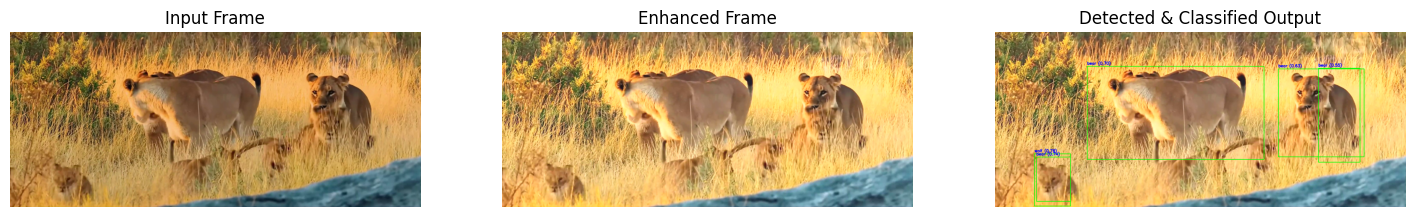

 90%|█████████ | 300/333 [00:58<00:05,  6.00it/s]

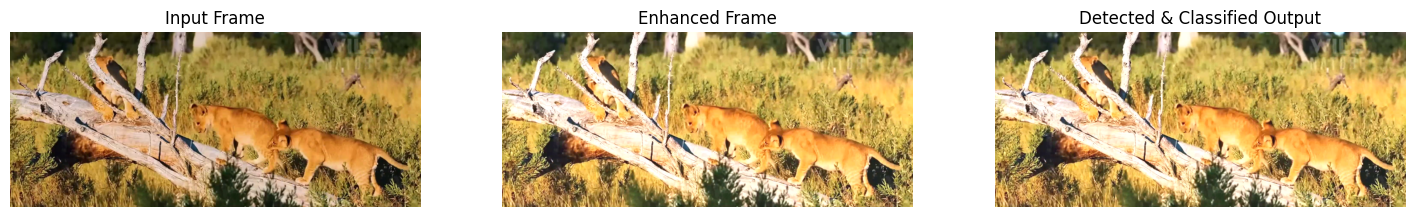

 99%|█████████▉| 330/333 [01:03<00:00,  6.01it/s]

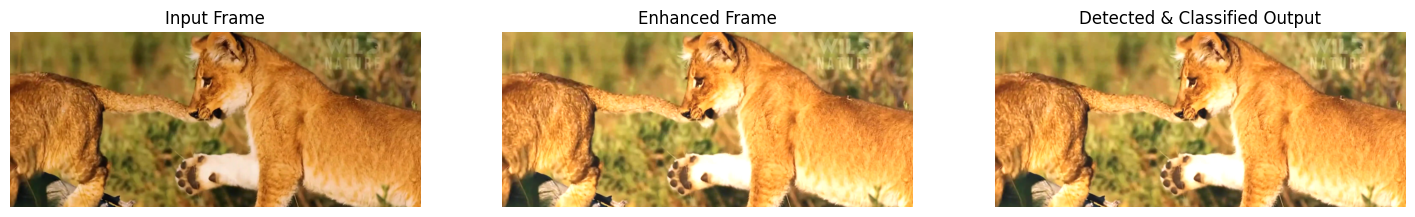

100%|██████████| 333/333 [01:04<00:00,  5.13it/s]


In [ ]:
for i in tqdm(range(total_frames)):
    ret, frame = cap.read()
    if not ret:
        break

    input_frame = frame.copy()

    # optional enhancement
    enhanced_frame = cv2.convertScaleAbs(frame, alpha=1.2, beta=15)

    # prepare tensor
    img_tensor = torch.from_numpy(enhanced_frame).permute(2,0,1).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)[0]

    output_frame = enhanced_frame.copy()

    boxes = outputs["boxes"].cpu().numpy()
    labels = outputs["labels"].cpu().numpy()
    scores = outputs["scores"].cpu().numpy()

    for box, label, score in zip(boxes, labels, scores):
        if score < 0.5:   # confidence threshold
            continue

        x1,y1,x2,y2 = map(int, box)
        class_name = classes[label-1]

        cv2.rectangle(output_frame, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(
            output_frame,
            f"{class_name} ({score:.2f})",
            (x1, y1-8),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255,0,0),
            2
        )

    out.write(output_frame)

    # display every 30 frames
    if i % 30 == 0:
        fig, axs = plt.subplots(1,3,figsize=(18,6))

        axs[0].imshow(cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Input Frame")
        axs[0].axis("off")

        axs[1].imshow(cv2.cvtColor(enhanced_frame, cv2.COLOR_BGR2RGB))
        axs[1].set_title("Enhanced Frame")
        axs[1].axis("off")

        axs[2].imshow(cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB))
        axs[2].set_title("Detected & Classified Output")
        axs[2].axis("off")

        plt.show()


In [ ]:
cap.release()
out.release()

print("✅ Inference completed successfully!")
files.download(out_path)

✅ Inference completed successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from IPython.display import HTML

print("✅ Inference completed successfully!")

HTML(f"""
<a href="{out_path}" download>
    <button style="
        font-size:18px;
        padding:10px 20px;
        background-color:#4CAF50;
        color:white;
        border:none;
        border-radius:5px;
        cursor:pointer;
    ">
        ⬇️ Download Output Video
    </button>
</a>
""")

✅ Inference completed successfully!
